# ARIMA modeling

In [1]:
# import libraries
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [3]:
# import datasets
cases_df = pd.read_csv('../clean_data/Cases_Normalized_per_100k.csv')
cases_df.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
0,Alameda,29.0,0.0,29,0,2020-03-18,0.019,0.008,0.055,0.123,0.795,1671329,1.735146,1.735146,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Alameda,36.0,0.0,7,0,2020-03-19,0.019,0.008,0.055,0.123,0.795,1671329,2.153974,0.418828,0.000000,0.000000,NaN,NaN,NaN,NaN
2,Alameda,42.0,0.0,6,0,2020-03-20,0.019,0.008,0.055,0.123,0.795,1671329,2.512970,0.358996,0.000000,0.000000,NaN,NaN,NaN,NaN
3,Alameda,62.0,0.0,20,0,2020-03-21,0.019,0.008,0.055,0.123,0.795,1671329,3.709623,1.196652,0.000000,0.000000,NaN,NaN,NaN,NaN
4,Alameda,72.0,1.0,10,1,2020-03-22,0.019,0.008,0.055,0.123,0.795,1671329,4.307949,0.598326,0.059833,0.059833,NaN,NaN,NaN,NaN


In [4]:
cases_df.describe()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
count,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,17776.000000,1.777600e+04,17776.000000,17776.000000
mean,1.327444e+04,210.774443,173.013187,2.048003,0.032279,0.030699,0.063650,0.158545,0.714792,6.823606e+05,1542.530785,20.284986,19.606417,0.210988,20.232502,2.081917e-01,172.290086,2.001583
std,5.201773e+04,852.430551,814.985729,11.017366,0.028533,0.026178,0.033898,0.040410,0.092762,1.456208e+06,2084.332897,43.944282,28.624650,0.831238,31.417552,4.040341e-01,775.800926,9.438015
min,0.000000e+00,0.000000,-1157.000000,-16.000000,0.001000,0.000000,0.004000,0.058000,0.482000,1.129000e+03,0.000000,-74.546183,0.000000,-5.543545,-6.977150,-7.919349e-01,-1.142857,-1.428571
25%,9.400000e+01,1.000000,1.000000,0.000000,0.015000,0.013000,0.040000,0.134000,0.661000,4.590500e+04,99.646385,0.606875,1.002456,0.000000,2.049615,1.522592e-15,2.000000,0.000000
50%,1.044000e+03,15.000000,14.000000,0.000000,0.023000,0.023000,0.058000,0.156000,0.737000,1.928430e+05,711.532789,6.700781,8.138623,0.000000,8.310360,5.983262e-02,18.285714,0.142857
75%,8.147250e+03,114.000000,85.000000,0.000000,0.043000,0.043000,0.084000,0.186000,0.786000,7.621480e+05,2248.121154,22.165620,27.829294,0.000000,24.251025,2.301092e-01,89.464286,1.000000
max,1.048757e+06,15260.000000,28549.000000,318.000000,0.140000,0.135000,0.162000,0.276000,0.889000,1.003911e+07,15791.711641,1860.053144,272.052534,27.717723,566.793296,6.335479e+00,15711.142857,241.285714


In [5]:
# convert date to datetime
cases_df['date'] = pd.to_datetime(cases_df['date'])

In [6]:
# drop no longer needed columns
cases_df.drop(['totalcountconfirmed', 'totalcountdeaths', 'newcountconfirmed',
              'newcountdeaths', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 
              'ALWAYS', 'deathper100k', 'newdeath100k', 'confirmedper100k', 'population',
               'newlyconfirmedper100k' ,'7dayrollingavg_newlyconfirmed_rawnumber', '7dayrollingavg_newdeath_rawnumber'], 
             axis = 1, inplace = True)
cases_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath
0,Alameda,2020-03-18,NaN,NaN
1,Alameda,2020-03-19,NaN,NaN
2,Alameda,2020-03-20,NaN,NaN
3,Alameda,2020-03-21,NaN,NaN
4,Alameda,2020-03-22,NaN,NaN


In [7]:
hospitals_df = pd.read_csv('../clean_data/hospitals_by_county.csv')
hospitals_df.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Plumas,2020-03-29,0.0,1.0,1.0,NaN,0.0,1.0,NaN
1,Tehama,2020-03-29,0.0,0.0,0.0,308.0,0.0,0.0,2.0
2,Glenn,2020-03-29,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,Mono,2020-03-29,0.0,1.0,1.0,308.0,0.0,0.0,2.0
4,Marin,2020-03-29,7.0,13.0,20.0,493.0,2.0,6.0,11.0


In [8]:
hospitals_df['todays_date'] = pd.to_datetime(hospitals_df['todays_date'])

In [9]:
hospitals_df.drop(['hospitalized_covid_confirmed_patients', 'hospitalized_suspected_covid_patients', 
                   'icu_covid_confirmed_patients', 'icu_suspected_covid_patients'],
                 axis = 1, inplace = True)
hospitals_df.head()

,county,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Plumas,2020-03-29,1.0,NaN,NaN
1,Tehama,2020-03-29,0.0,308.0,2.0
2,Glenn,2020-03-29,0.0,NaN,NaN
3,Mono,2020-03-29,1.0,308.0,2.0
4,Marin,2020-03-29,20.0,493.0,11.0


In [10]:
cases_hosp_df = cases_df.merge(hospitals_df, how = 'inner', left_on = ['county','date'], right_on = ['county', 'todays_date'])
cases_hosp_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Alameda,2020-03-29,1.153915,0.042738,2020-03-29,127.0,2725.0,119.0
1,Alameda,2020-03-30,1.384698,0.051285,2020-03-30,148.0,3283.0,146.0
2,Alameda,2020-03-31,1.478721,0.042738,2020-03-31,150.0,1857.0,77.0
3,Alameda,2020-04-01,1.307770,0.042738,2020-04-01,128.0,2456.0,106.0
4,Alameda,2020-04-02,1.478721,0.051285,2020-04-02,133.0,2580.0,112.0


In [11]:
# do a group by so we can create predictions per county
county_df = cases_hosp_df.groupby(['county', 'date']).mean()

In [12]:
county_df.index.get_level_values('county').unique()[0]

'Alameda'

In [13]:
# start by analyzing LA County
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


## Pilot modeling using Los Angeles

In [14]:
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [15]:
la_df = county_df.loc['Los Angeles'].tail(110)
features = ['hospitalized_covid_patients', '7dayrollingavg_newdeath', 'all_hospital_beds', 'icu_available_beds']
X = la_df[features]
y = la_df[['7dayrollingavg_newlyconfirmed']]

In [16]:

X_train = X.iloc[:92]
X_test = X.iloc[92:]
y_train = y.iloc[:92]
y_test = y.iloc[92:]
X_train.tail()

,hospitalized_covid_patients,7dayrollingavg_newdeath,all_hospital_beds,icu_available_beds
date,,,,
2021-01-02,7971.0,1.770220,20244.0,327.0
2021-01-03,8203.0,1.837101,20328.0,326.0
2021-01-04,8318.0,1.842793,20371.0,338.0
2021-01-05,8422.0,1.834255,20495.0,313.0
2021-01-06,8385.0,1.810064,20435.0,328.0


In [17]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pmdarima as pm

In [19]:
smodel = pm.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=575.359, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=649.159, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=611.739, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=647.160, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=576.989, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=576.229, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=574.601, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=576.291, Time=0.08 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=577.940, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=572.608, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=575.638, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=574.247, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=574.308, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=573.362, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -283.304
Date:                Thu, 28 Jan 2021   AIC                            572.608
Time:                        21:30:02   BIC                            580.108
Sample:                             0   HQIC                           575.632
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1881      0.052    -22.820      0.000      -1.290      -1.086
ma.L2          0.2782      0.064      4.330      0.000       0.152       0.404
sigma2        30.9944      2.022     15.330      0.000      27.032      34.957
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               298.43
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              34.47   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

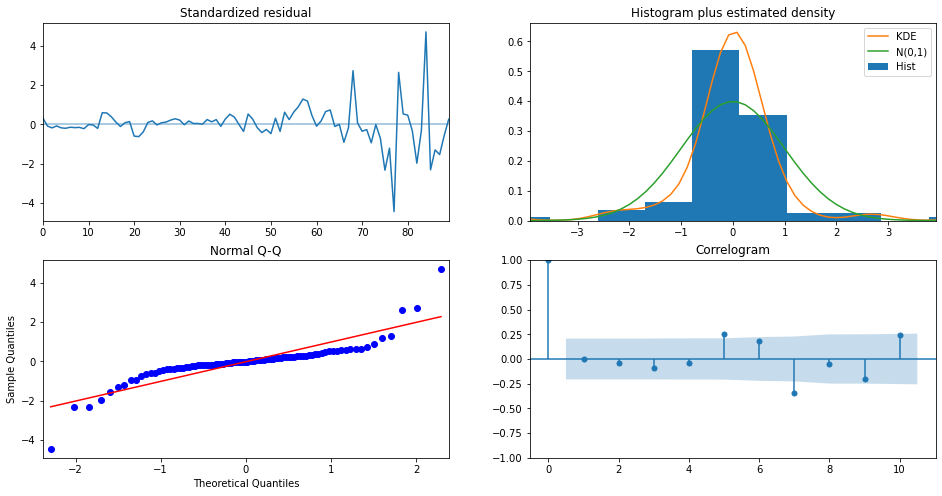

In [20]:
plt_smodel = smodel.plot_diagnostics(figsize=(16, 8))
plt_smodel.show()
plt_smodel.savefig('../images/arima_model_diags.png')

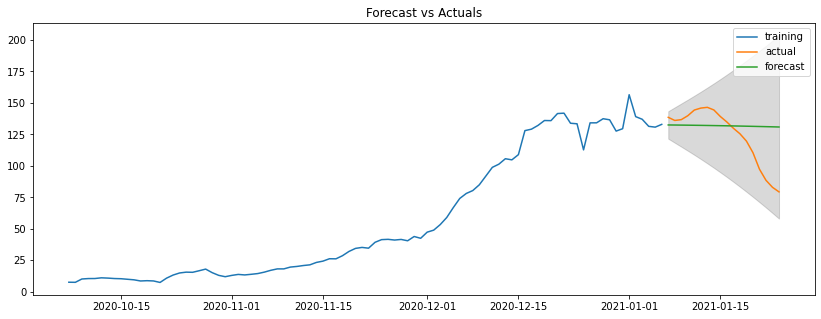

In [25]:
# warnings.filterwarnings("ignore") 

# model = ARIMA(y_train, order=smodel.order)  
# fitted = model.fit(disp=-1)  
# print(fitted.summary())
# # Forecast
# fc, se, conf = fitted.forecast(18, alpha=0.05)  # 95% conf

# # Make as pandas series
# fc_series = pd.Series(fc, index=y_test.index)
# lower_series = pd.Series(conf[:, 0], index=y_test.index)
# upper_series = pd.Series(conf[:, 1], index=y_test.index)

# Plot
plt.figure(figsize=(14,5))
plt.plot(y_train, label='training')
plt.plot(y_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend()
plt.savefig('../images/arima_la_county.png');

In [22]:
print('MSE of our forecast is:', mean_squared_error(y_test, fc_series, squared=True))
print('RMSE of our forecast is:', mean_squared_error(y_test, fc_series, squared=False))

MSE of our forecast is: 524.1636509856758
RMSE of our forecast is: 22.894620568720413


In [23]:
smodel = pm.auto_arima(y, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=684.987, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=761.359, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=718.901, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=686.186, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=759.361, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=686.897, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=686.522, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=684.739, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=686.600, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=687.512, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=683.386, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=684.809, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=685.147, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=685.232, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=683.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -338.693
Date:                Thu, 28 Jan 2021   AIC                            683.386
Time:                        21:30:06   BIC                            691.432
Sample:                             0   HQIC                           686.648
                                - 110                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0460      0.050    -21.016      0.000      -1.144      -0.948
ma.L2          0.1922      0.065      2.938      0.003       0.064       0.320
sigma2        30.5668      1.908     16.017      0.000      26.827      34.307
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               353.54
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              40.14   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

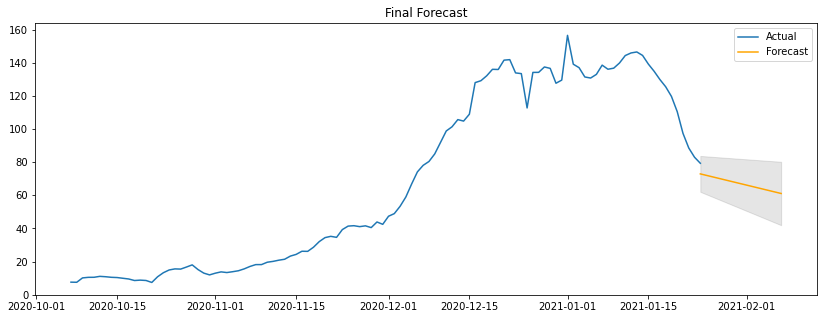

In [26]:
# Forecast
n_periods = 3
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y.index[-1], periods=n_periods, freq='W')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot

fig = plt.figure(figsize=(14, 5))

plt.plot(y, label="Actual")
plt.plot(fitted_series, color='orange', label='Forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.1)

plt.title('Final Forecast')
plt.legend()
plt.show()

# Modeling for 7 Counties Highest New Cases/100k 
- These 7 counties have 500+ daily newly confirmed cases per 100k (7 day average) with an increasing trend
- we will model these counties for predictions 

In [27]:
hotspot_counties = ['Tehama', 'Riverside', 'Colusa', 'Merced', 'Santa Barbara', 'Inyo', 'Tulare']

features = ['hospitalized_covid_patients', '7dayrollingavg_newdeath', 'all_hospital_beds', 'icu_available_beds']


## Tehama County

Tehama = county_df.loc['Tehama'].tail(110)
Riverside = county_df.loc['Riverside'].tail(110)
Colusa = county_df.loc['Colusa'].tail(110)
Merced = county_df.loc['Merced'].tail(110)
Santa_Barbara = county_df.loc['Santa Barbara'].tail(110)
Inyo = county_df.loc['Inyo'].tail(110)
Tulare = county_df.loc['Tulare'].tail(110)

In [28]:
# build a function to incorporate everything 
warnings.filterwarnings("ignore") 
def arima_model (countydf):
    X = countydf[features]
    y = countydf[['7dayrollingavg_newlyconfirmed']]   
    X_train = X.iloc[:92]
    X_test = X.iloc[92:]
    y_train = y.iloc[:92]
    y_test = y.iloc[92:]
    
    smodel = pm.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

    print(smodel.summary())

    model = ARIMA(y_train, order=smodel.order)  
    fitted = model.fit(disp=-1)  
    print(fitted.summary())
    # Forecast
    fc, se, conf = fitted.forecast(18, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=y_test.index)
    lower_series = pd.Series(conf[:, 0], index=y_test.index)
    upper_series = pd.Series(conf[:, 1], index=y_test.index)

    # Plot
    plt.figure(figsize=(14,5))
    plt.plot(y_train, label='training')
    plt.plot(y_test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend()
    plt.show()



    print('MSE of our forecast is:', mean_squared_error(y_test, fc_series, squared=True))
    print('RMSE of our forecast is:', mean_squared_error(y_test, fc_series, squared=False))


    
    # use the whole dataset to make actual predictions
    
    smodel = pm.auto_arima(y, start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=False,
                             d=None, D=None, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

    print(smodel.summary())


    # Forecast
    n_periods = 3
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(y.index[-1], periods=n_periods, freq='W')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot

    fig = plt.figure(figsize=(14, 5))

    plt.plot(y, label="Actual")
    plt.plot(fitted_series, color='orange', label='Forecast')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.1)

    plt.title('Final Forecast')
    plt.legend()
    plt.show()
    print(fitted_series)
    return 

## Tehama County

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=596.915, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=567.628, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=594.944, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=554.762, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=547.391, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=543.793, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=542.016, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=545.566, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,2

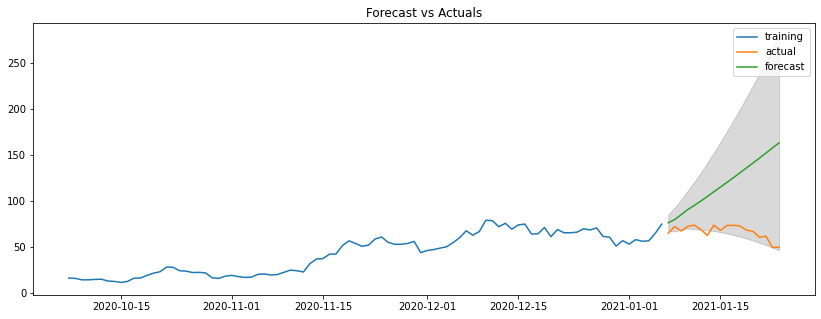

MSE of our forecast is: 3665.445480922672
RMSE of our forecast is: 60.5429226328121
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=653.938, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=654.595, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=652.013, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=652.508, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=653.046, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=653.909, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=655.115, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=650.691, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=652.523, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=652.574, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=651.216, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=653.454, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.653 seconds
                

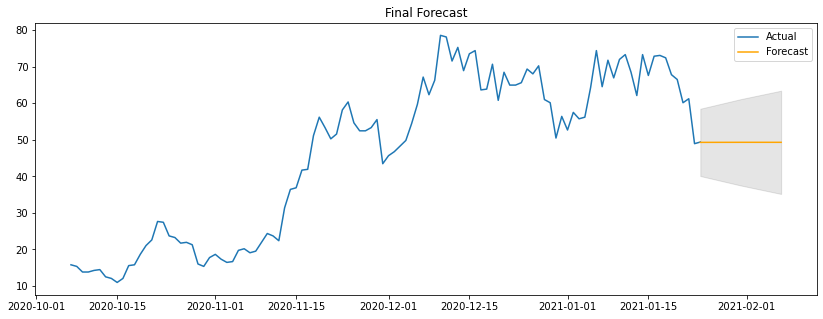

2021-01-24    49.300240
2021-01-31    49.317279
2021-02-07    49.313922
Freq: W-SUN, dtype: float64


In [29]:
arima_model(Tehama)

## Riverside County

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=563.188, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=581.413, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=561.905, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=564.721, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=584.545, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=562.932, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=564.921, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=561.854, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=563.251, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=563.352, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=566.089, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=565.251, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.373 seconds
                               SARIMAX Results                                
Dep. Variable:       

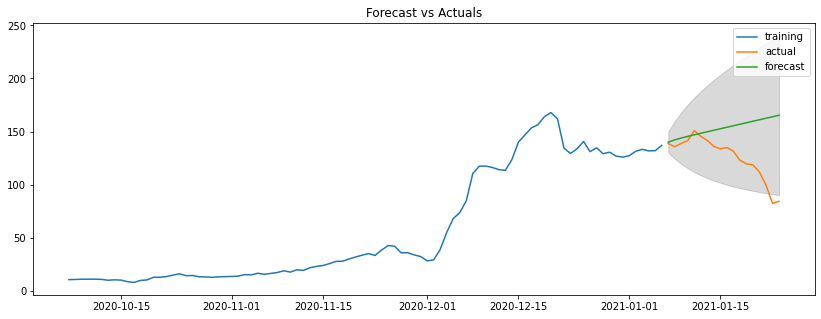

MSE of our forecast is: 1428.9265775463396
RMSE of our forecast is: 37.80114518829211
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=681.099, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=704.927, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=679.688, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=683.758, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=704.297, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=680.932, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=682.930, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=678.200, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=679.573, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=679.689, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=682.697, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=681.573, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.559 seconds
              

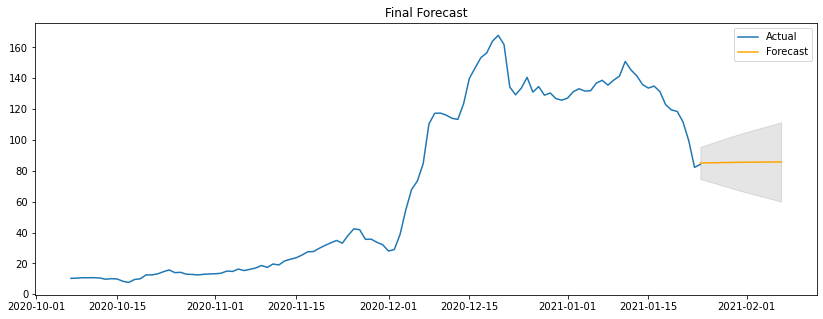

2021-01-24    85.122324
2021-01-31    85.561050
2021-02-07    85.769222
Freq: W-SUN, dtype: float64


In [30]:
## Riverside County

arima_model(Riverside)

## Colusa County

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=637.091, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=635.615, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=637.548, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=637.493, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=634.508, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.146 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -316.254
Date:                Thu, 28 Jan 2021   AIC                            634.508
Time:                        20:54:26   BIC                            637.019
Sample:                             0   HQIC                           635.521
                                 - 92                                         
Co

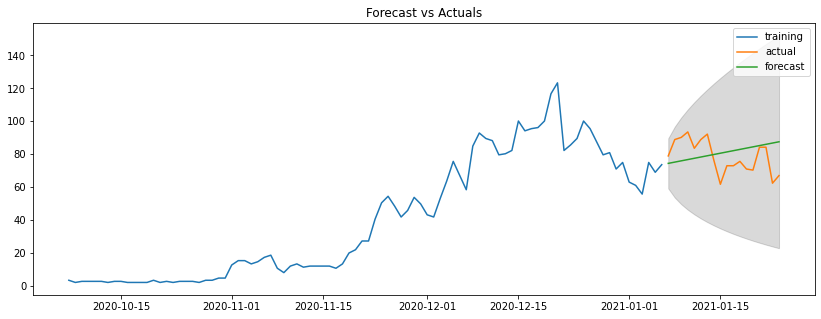

MSE of our forecast is: 165.25195474667112
RMSE of our forecast is: 12.855036162791263
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=769.384, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=768.846, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=770.750, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=770.645, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=767.414, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.235 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -382.707
Date:                Thu, 28 Jan 2021   AIC                            767.414
Time:                        20:54:26   BIC                            770.105
Sample:                             0   HQIC                           76

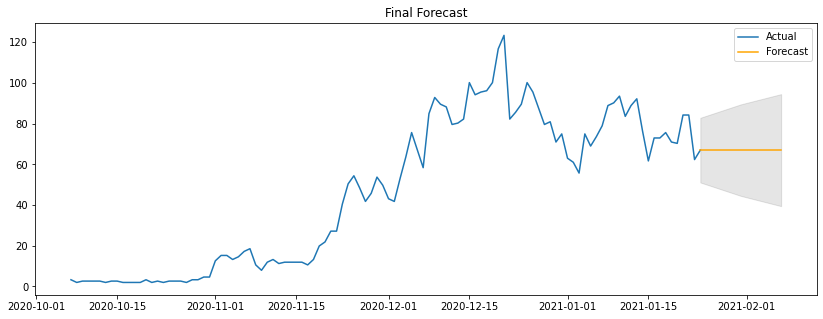

2021-01-24    66.96325
2021-01-31    66.96325
2021-02-07    66.96325
Freq: W-SUN, dtype: float64


In [31]:
## Colusa County

arima_model(Colusa)

## Merced County

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=558.921, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=530.665, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=556.940, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=531.169, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=528.698, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=529.206, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=515.151, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=510.706, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2

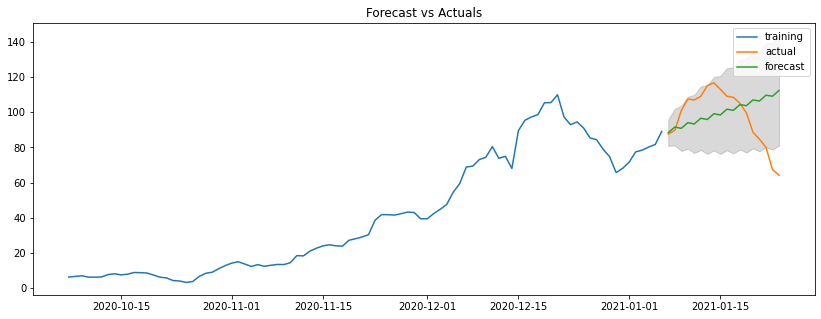

MSE of our forecast is: 412.6390422926868
RMSE of our forecast is: 20.313518707813444
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=629.203, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=672.651, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=644.454, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=627.248, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=670.655, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=629.204, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=623.932, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=622.200, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=631.199, Time=0.06 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=616.204, Time=0.18 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=621.181, Time=0.18 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=620.843, Time=0.11 sec
 ARIMA(2,2,3)(0,0,0)[0]       

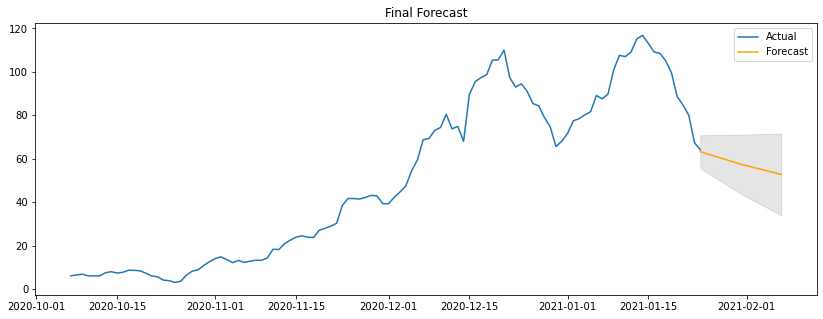

2021-01-24    63.227179
2021-01-31    57.500113
2021-02-07    52.784662
Freq: W-SUN, dtype: float64


In [32]:
## Merced County## Merced County

arima_model(Merced)

## Santa Barbara County

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=468.053, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=415.870, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=466.084, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=397.520, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=391.290, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=387.236, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=385.448, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=387.307, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=385.307, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=383.646, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=385.289, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=382.768, Time=0.0

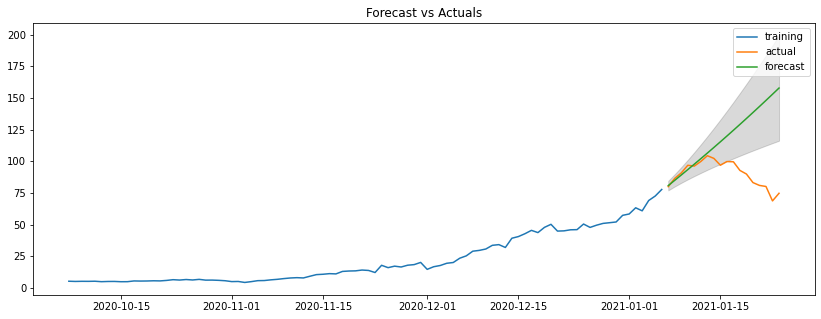

MSE of our forecast is: 1681.2540674881714
RMSE of our forecast is: 41.00309826693797
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=522.577, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=605.575, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=552.531, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=534.631, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=603.598, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=519.406, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=527.126, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=519.648, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=515.341, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=514.728, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=512.848, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=514.677, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=515.725, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0]   

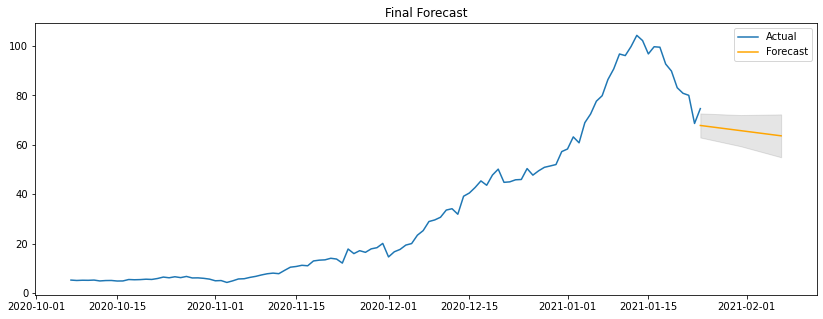

2021-01-24    67.848888
2021-01-31    65.751342
2021-02-07    63.653797
Freq: W-SUN, dtype: float64


In [33]:
## Santa Barbara County## Santa Barbara County

arima_model(Santa_Barbara)

## Inyo County

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=602.481, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=601.693, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=602.401, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=601.458, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=600.089, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.138 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -299.044
Date:                Thu, 28 Jan 2021   AIC                            600.089
Time:                        20:54:34   BIC                            602.600
Sample:                             0   HQIC                           601.102
                                 - 92                                         
Co

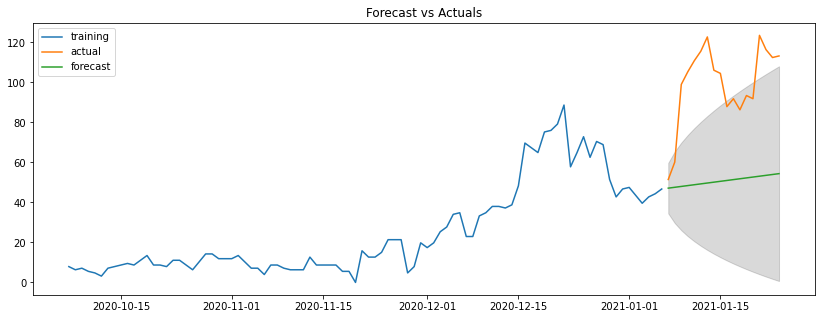

MSE of our forecast is: 2714.2434887620243
RMSE of our forecast is: 52.09840197896692
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=773.685, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=769.830, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=771.685, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=771.685, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=769.363, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -383.682
Date:                Thu, 28 Jan 2021   AIC                            769.363
Time:                        20:54:35   BIC                            772.055
Sample:                             0   HQIC                           770

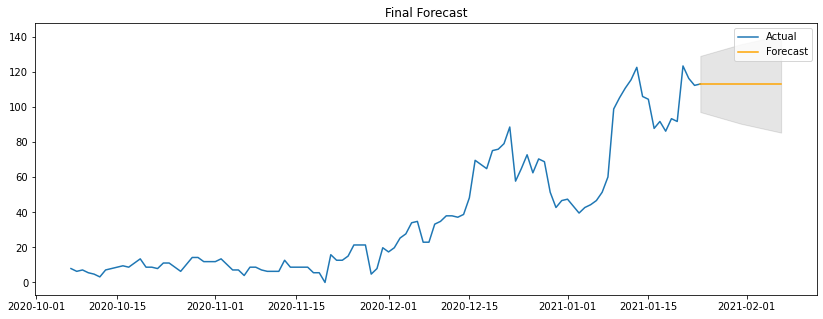

2021-01-24    113.246696
2021-01-31    113.246696
2021-02-07    113.246696
Freq: W-SUN, dtype: float64


In [34]:
## Inyo County## Tulare County## Inyo County

arima_model(Inyo)

## Tulare County

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=556.066, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=551.819, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=523.460, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=554.066, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=521.514, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=549.819, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.840 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. O

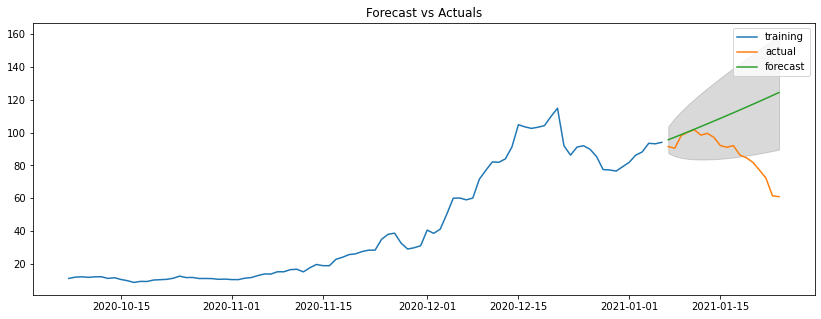

MSE of our forecast is: 894.2126972671845
RMSE of our forecast is: 29.90338939430085
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=622.065, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=663.692, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=656.375, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=623.564, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=661.693, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=621.872, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=620.253, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=621.252, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=621.584, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=618.544, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=621.842, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=620.161, Time=0.10 sec
 ARIMA(0,2,3)(0,0,0)[0]        

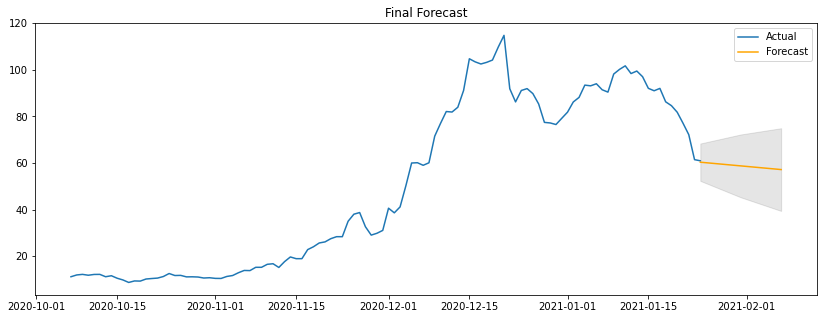

2021-01-24    60.375035
2021-01-31    58.793374
2021-02-07    57.211712
Freq: W-SUN, dtype: float64


In [35]:
## Tulare County

arima_model(Tulare)